# 2021-03-24 WS2_1 Speech Processing: Audio Command Recognition


This tutorial is based on the [Simple audio recognition: Recognizing keywords](https://www.tensorflow.org/tutorials/audio/simple_audio) tutorial by TensorFlow but makes it also work on a mobile phone. It shows how to build and run a simple speech recognition TF model. Once you’ve completed this tutorial, you’ll have a application that tries to classify a one second audio clip as either silence, an unknown word, “yes”, “no”, “up”, “down”, “left”, “right”, “on”, “off”, “stop”, or “go”.

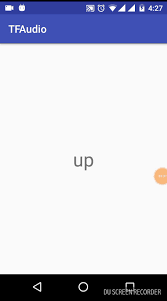

* <a href="https://github.com/EN10/SimpleSpeech/tree/master/test"><b>Pre-trained Model</b></a>
* <a href="https://www.tensorflow.org/tutorials/audio_recognition"><b>Model Code and Tutorial</b></a>
* <a href="https://github.com/Thumar/audio-recognition"><b>App Source Code</b></a>


<div class="alert alert-block alert-success">
<b>Follow the TensorFlow tutorial</b>:
<ul><li>Use Google Colab: <a href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">Simple audio recognition: Recognizing keywords</a></li></ul>
</div>

<p align="center">
    <table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/simple_audio">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/simple_audio.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>
</p>

## 1. Building / Training / Testing a Model

You can train your model on your laptop, or on a server, and then use that pre-trained model on our mobile device. Alternatively, you can use an already <a href="http://download.tensorflow.org/models/speech_commands_v0.01.zip">pre-trained model</a>.


## 2. Android App

Android <a href="https://github.com/Thumar/audio-recognition">app source code</a>. You need to copy model files to the assets folder and specify correct paths in MainActivity.java.

To request microphone, you should be requesting RECORD_AUDIO permission in your manifest file as below:

```XML
<uses-permission android:name="android.permission.RECORD_AUDIO"/>
```

#### Microphone Permission

Since Android 6.0 Marshmallow, the application will not be granted any permission at installation time. Instead, the application has to ask the user for a permission one-by-one at runtime.

```Java
private void requestMicrophonePermission() {
        ActivityCompat.requestPermissions(MainActivity.this,
                new String[]{android.Manifest.permission.RECORD_AUDIO}, REQUEST_RECORD_AUDIO);
    }
@Override
public void onRequestPermissionsResult(int requestCode, String[] permissions, int[] grantResults) {
      if (requestCode == REQUEST_RECORD_AUDIO&& grantResults.length > 0
                && grantResults[0] == PackageManager.PERMISSION_GRANTED) {
            startRecording();
            startRecognition();
      }
 }
```

#### Recording Audio

The AudioRecord class manages the audio resources for Java applications to record audio from the audio input hardware of the platform. This is achieved by “pulling” (reading) the data from the AudioRecord object. The application is responsible for polling the AudioRecord object in time using read(short[], int, int).

```Java
private void record() {
        android.os.Process.setThreadPriority(android.os.Process.THREAD_PRIORITY_AUDIO);
 
        // Estimate the buffer size we'll need for this device.
        int bufferSize =
                AudioRecord.getMinBufferSize(
                        SAMPLE_RATE, AudioFormat.CHANNEL_IN_MONO, AudioFormat.ENCODING_PCM_16BIT);
        if (bufferSize == AudioRecord.ERROR || bufferSize == AudioRecord.ERROR_BAD_VALUE) {
            bufferSize = SAMPLE_RATE * 2;
        }
        short[] audioBuffer = new short[bufferSize / 2];
 
        AudioRecord record =
                new AudioRecord(
                        MediaRecorder.AudioSource.DEFAULT,
                        SAMPLE_RATE,
                        AudioFormat.CHANNEL_IN_MONO,
                        AudioFormat.ENCODING_PCM_16BIT,
                        bufferSize);
 
        if (record.getState() != AudioRecord.STATE_INITIALIZED) {
            Log.e(LOG_TAG, "Audio Record can't initialize!");
            return;
        }
 
        record.startRecording();
 
        Log.v(LOG_TAG, "Start recording");
 
        // Loop, gathering audio data and copying it to a round-robin buffer.
        while (shouldContinue) {
            int numberRead = record.read(audioBuffer, 0, audioBuffer.length);
            int maxLength = recordingBuffer.length;
            int newRecordingOffset = recordingOffset + numberRead;
            int secondCopyLength = Math.max(0, newRecordingOffset - maxLength);
            int firstCopyLength = numberRead - secondCopyLength;
            // We store off all the data for the recognition thread to access. The ML
            // thread will copy out of this buffer into its own, while holding the
            // lock, so this should be thread safe.
            recordingBufferLock.lock();
            try {
                System.arraycopy(audioBuffer, 0, recordingBuffer, recordingOffset, firstCopyLength);
                System.arraycopy(audioBuffer, firstCopyLength, recordingBuffer, 0, secondCopyLength);
                recordingOffset = newRecordingOffset % maxLength;
            } finally {
                recordingBufferLock.unlock();
            }
        }
 
        record.stop();
        record.release();
    }
```

#### Run TensorFlow Model

A TensorFlowInferenceInterface class that provides a smaller API surface suitable for inference and summarizing the performance of model execution.

```Java
private void recognize() {
    Log.v(LOG_TAG, "Start recognition");
 
    short[] inputBuffer = new short[RECORDING_LENGTH];
    float[] floatInputBuffer = new float[RECORDING_LENGTH];
    float[] outputScores = new float[labels.size()];
    String[] outputScoresNames = new String[]{OUTPUT_SCORES_NAME};
    int[] sampleRateList = new int[]{SAMPLE_RATE};
 
    // Loop, grabbing recorded data and running the recognition model on it.
    while (shouldContinueRecognition) {
            // The recording thread places data in this round-robin buffer, so lock to
            // make sure there's no writing happening and then copy it to our own
            // local version.
       recordingBufferLock.lock();
       try {
           int maxLength = recordingBuffer.length;
           int firstCopyLength = maxLength - recordingOffset;
           int secondCopyLength = recordingOffset;
           System.arraycopy(recordingBuffer, recordingOffset, inputBuffer, 0, firstCopyLength);
           System.arraycopy(recordingBuffer, 0, inputBuffer, firstCopyLength, secondCopyLength);
        } finally {
           recordingBufferLock.unlock();
         }
 
            // We need to feed in float values between -1.0f and 1.0f, so divide the
            // signed 16-bit inputs.
         for (int i = 0; i < RECORDING_LENGTH; ++i) {
             floatInputBuffer[i] = inputBuffer[i] / 32767.0f;
         }
 
            // Run the model.
       inferenceInterface.feed(SAMPLE_RATE_NAME, sampleRateList);
       inferenceInterface.feed(INPUT_DATA_NAME, floatInputBuffer, RECORDING_LENGTH, 1);
       inferenceInterface.run(outputScoresNames);
       inferenceInterface.fetch(OUTPUT_SCORES_NAME, outputScores);
 
       // Use the smoother to figure out if we've had a real recognition event.
       long currentTime = System.currentTimeMillis();
       final RecognizeCommands.RecognitionResult result = recognizeCommands.processLatestResults(outputScores, currentTime);
 
       runOnUiThread(
             new Runnable() {
                 @Override
                 public void run() {
                   // If we do have a new command, highlight the right list entry.
                      if (!result.foundCommand.startsWith("_") && result.isNewCommand) {
                            int labelIndex = -1;
                            for (int i = 0; i < labels.size(); ++i) {
                             if (labels.get(i).equals(result.foundCommand)) {
                                    labelIndex = i;
                              }
                         }
                         label.setText(result.foundCommand);
                    }
                }
              });
        try {
            // We don't need to run too frequently, so snooze for a bit.
            Thread.sleep(MINIMUM_TIME_BETWEEN_SAMPLES_MS);
        } catch (InterruptedException e) {
         // Ignore
        }
    }
 
    Log.v(LOG_TAG, "End recognition");
}
```

#### Recognize Commands
RecognizeCommands class is fed the output of running the TensorFlow model over time, it averages the signals and returns information about a label when it has enough evidence to think that a recognized word has been found. The implementation is fairly small, just keeping track of the last few predictions and averaging them.

```Java
public RecognitionResult processLatestResults(float[] currentResults, long currentTimeMS) {
        if (currentResults.length != labelsCount) {
            throw new RuntimeException(
                    "The results for recognition should contain "
                            + labelsCount
                            + " elements, but there are "
                            + currentResults.length);
        }
 
        if ((!previousResults.isEmpty()) && (currentTimeMS < previousResults.getFirst().first)) {
            throw new RuntimeException(
                    "You must feed results in increasing time order, but received a timestamp of "
                            + currentTimeMS
                            + " that was earlier than the previous one of "
                            + previousResults.getFirst().first);
        }
 
        final int howManyResults = previousResults.size();
        // Ignore any results that are coming in too frequently.
        if (howManyResults > 1) {
            final long timeSinceMostRecent = currentTimeMS - previousResults.getLast().first;
            if (timeSinceMostRecent < minimumTimeBetweenSamplesMs) {
                return new RecognitionResult(previousTopLabel, previousTopLabelScore, false);
            }
        }
 
        // Add the latest results to the head of the queue.
        previousResults.addLast(new Pair<Long, float[]>(currentTimeMS, currentResults));
        Log.d(TAG, currentResults + " " + currentTimeMS);
 
        // Prune any earlier results that are too old for the averaging window.
        final long timeLimit = currentTimeMS - averageWindowDurationMs;
        while (previousResults.getFirst().first < timeLimit) {
            previousResults.removeFirst();
        }
        // If there are too few results, assume the result will be unreliable and
        // bail.
        final long earliestTime = previousResults.getFirst().first;
        final long samplesDuration = currentTimeMS - earliestTime;
        if ((howManyResults < minimumCount)
                || (samplesDuration < (averageWindowDurationMs / MINIMUM_TIME_FRACTION))) {
            Log.v("RecognizeResult", "Too few results");
            return new RecognitionResult(previousTopLabel, 0.0f, false);
        }
 
        // Calculate the average score across all the results in the window.
        float[] averageScores = new float[labelsCount];
        for (Pair<Long, float[]> previousResult : previousResults) {
            final float[] scoresTensor = previousResult.second;
            int i = 0;
            while (i < scoresTensor.length) {
                averageScores[i] += scoresTensor[i] / howManyResults;
                ++i;
            }
        }
 
        // Sort the averaged results in descending score order.
        ScoreForSorting[] sortedAverageScores = new ScoreForSorting[labelsCount];
        for (int i = 0; i < labelsCount; ++i) {
            sortedAverageScores[i] = new ScoreForSorting(averageScores[i], i);
        }
        Arrays.sort(sortedAverageScores);
 
        // See if the latest top score is enough to trigger a detection.
        final int currentTopIndex = sortedAverageScores[0].index;
        final String currentTopLabel = labels.get(currentTopIndex);
        final float currentTopScore = sortedAverageScores[0].score;
        // If we've recently had another label trigger, assume one that occurs too
        // soon afterwards is a bad result.
        long timeSinceLastTop;
        if (previousTopLabel.equals(SILENCE_LABEL) || (previousTopLabelTime == Long.MIN_VALUE)) {
            timeSinceLastTop = Long.MAX_VALUE;
        } else {
            timeSinceLastTop = currentTimeMS - previousTopLabelTime;
        }
        boolean isNewCommand;
        if ((currentTopScore > detectionThreshold) && (timeSinceLastTop > suppressionMs)) {
            previousTopLabel = currentTopLabel;
            previousTopLabelTime = currentTimeMS;
            previousTopLabelScore = currentTopScore;
            isNewCommand = true;
        } else {
            isNewCommand = false;
        }
        return new RecognitionResult(currentTopLabel, currentTopScore, isNewCommand);
    }
```

The demo app updates its UI of results automatically based on the labels text file you copy into assets alongside your frozen graph, which means you can easily try out different models without needing to make any code changes. You will need to update LABEL_FILENAME and MODEL_FILENAME to point to the files you’ve added if you change the paths though.

You can easily replace it with a model you’ve trained yourself. If you do this, you’ll need to make sure that the constants in the main MainActivity Java source file like SAMPLE_RATE and SAMPLE_DURATION match any changes you’ve made to the defaults while training. You’ll also see that there’s a Java version of the RecognizeCommands module that’s very similar to the C++ version in this tutorial. If you’ve tweaked parameters for that, you can also update them in MainActivity to get the same results as in your server testing.


***
## Related Examples and Useful Links

* <a href="https://medium.com/iotforall/sound-classification-with-tensorflow-8209bdb03dfb">Sound Classification with TensorFlow</a>
* <a href="https://www.codementor.io/vishnu_ks/audio-classification-using-image-classification-techniques-hx63anbx1">Audio classification using Image classification techniques</a>


***
## Credits
* <a href="https://www.tensorflow.org/tutorials/audio_recognition">Simple Audio Recognition</a>
* <a href="http://androidkt.com/speech-recognition-using-tensorflow/">Speech Recognition Using TensorFlow</a>